# 0. GPU Setting

In [1]:
import torch
from torch import nn
import torch.nn.functional as F

/Users/s2hee/opt/anaconda3/envs/sehee/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(5,5)
 
    def forward(self,x):
        net = self.lin1(x)
        return net

In [3]:
device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
print(f"device: {device}")

device: mps


In [4]:
# MPS 장치에 바로 tensor를 생성합니다.
x = torch.ones(5, device=device)
 
# GPU 상에서 연산 진행
y = x * 2
 
# 또는, 다른 장치와 마찬가지로 MPS로 이동할 수도 있습니다.
model = Net()# 어떤 모델의 객체를 생성한 뒤,
model.to(device) # MPS 장치로 이동합니다.
 
# 이제 모델과 텐서를 호출하면 GPU에서 연산이 이뤄집니다.
pred = model(x)
print(pred)

tensor([ 0.4866,  0.7781,  1.3764, -0.6059,  0.5537], device='mps:0',
       grad_fn=<LinearBackward0>)


/Users/s2hee/opt/anaconda3/envs/sehee/lib/python3.9/site-packages/torch/_tensor_str.py:115: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1667808783679/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(


In [5]:
print (f"PyTorch version:{torch.__version__}") # 1.12.1 이상
print(f"MPS 장치를 지원하도록 build 되었는지: {torch.backends.mps.is_built()}") # True 여야 합니다.
print(f"MPS 장치가 사용 가능한지: {torch.backends.mps.is_available()}") # True 여야 합니다.
!python -c 'import platform;print(platform.platform())'

PyTorch version:1.14.0.dev20221107
MPS 장치를 지원하도록 build 되었는지: True
MPS 장치가 사용 가능한지: True
macOS-10.16-x86_64-i386-64bit


In [6]:
import os
import random
from sklearn.model_selection import train_test_split
import torchvision.transforms.functional as TF

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2

import numpy as np
import matplotlib.pyplot as plt

# U-Net with Residual unit

In [7]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, padding):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
        )
        """ Residual block과 channel size를 맞추기 위한 conv operation """
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1),
        ) 
    
    def forward(self, inputs):
        r = self.conv_block(inputs)
        s = self.shortcut(inputs)
        
        skip = r + s
        return skip

class ResUNet(nn.Module):
    def __init__(self, num_classes):
        super(ResUNet, self).__init__()
        self.num_classes = num_classes
        
        """ Encoder input layer """
        self.contl_1 = self.input_block(in_channels=3, out_channels=64)
        self.contl_2 = self.input_skip(in_channels=3, out_channels=64)
        
        """ Residual encoder block """
        self.resdl_1 = ResidualBlock(64, 128, 2, 1)
        self.resdl_2 = ResidualBlock(128, 256, 2, 1)
        #self.resdl_3 = ResidualBlock(256, 512, 2, 1)
        
        """ Encoder decoder skip connection """
        self.middle = ResidualBlock(256, 512, 2, 1)
        
        """ Decoder block """
        self.expnl_1 = nn.ConvTranspose2d(in_channels=512, out_channels=256, 
                                          kernel_size=2, stride=2, padding=0)
        self.expnl_1_cv = ResidualBlock(256+256, 256, 1, 1)
        self.expnl_2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, 
                                          kernel_size=2, stride=2, padding=0)
        self.expnl_2_cv = ResidualBlock(128+128, 128, 1, 1)
        self.expnl_3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, 
                                          kernel_size=2, stride=2, padding=0)
        self.expnl_3_cv = ResidualBlock(64+64, 64, 1, 1)
        # self.expnl_4 = nn.ConvTranspose2d(in_channels=128, out_channels=128, 
        #                                   kernel_size=2, stride=2, padding=0)
        # self.expnl_4_cv = ResidualBlock(128+64, 64, 1, 1)
        
        self.output = nn.Sequential(
          nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1),
          nn.Sigmoid(),
        )
        
    def input_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    )
        return block
    
    def input_skip(self, in_channels, out_channels):
        skip = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        return skip                         
    
    def forward(self, X):
        contl_1_out = self.contl_1(X) # 64
        contl_2_out = self.contl_2(X) # 64
        input_out = contl_1_out + contl_2_out
        
        resdl_1_out = self.resdl_1(input_out) # 128
        resdl_2_out = self.resdl_2(resdl_1_out) # 256
        #resdl_3_out = self.resdl_3(resdl_2_out) # 512
        
        middle_out = self.middle(resdl_2_out) # 512
        
        expnl_1_out = self.expnl_1(middle_out)
        expnl_1_cv_out = self.expnl_1_cv(torch.cat((expnl_1_out, resdl_2_out), dim=1)) # 512
        expnl_2_out = self.expnl_2(expnl_1_cv_out) # 256
        expnl_2_cv_out = self.expnl_2_cv(torch.cat((expnl_2_out, resdl_1_out), dim=1))
        expnl_3_out = self.expnl_3(expnl_2_cv_out)
        expnl_3_cv_out = self.expnl_3_cv(torch.cat((expnl_3_out, contl_1_out), dim=1))
        # expnl_4_out = self.expnl_4(expnl_3_cv_out)
        # expnl_4_cv_out = self.expnl_4_cv(torch.cat((expnl_4_out, input_out), dim=1))
        
        out = self.output(expnl_3_cv_out)
        return out

In [8]:
# iou definition
def iou(pred, target, n_classes = 2):
    
    iou = []
    pred = pred.view(-1)
    target = target.view(-1)

    # Ignore IoU for background class ("0")
    for cls in range(1, n_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds[target_inds]).long().sum().data.cpu().item()
        union = pred_inds.long().sum().data.cpu().item() + target_inds.long().sum().data.cpu().item() - intersection

        if union == 0:
            iou.append(float('nan'))  # If there is no ground truth, do not include in evaluation
        else:
            iou.append(float(intersection) / float(max(union, 1)))

    return sum(iou)

In [9]:
import numpy as np
def iou_metric(y_pred, y_true, n_classes = 2):
    miou = []
    for i in np.arange(0.5, 1.0, 0.05):
        y_pred_ = (y_pred > i)
        iou_init = iou(y_pred_, y_true, n_classes = n_classes)
        miou.append(iou_init)
    
    return sum(miou)/len(miou)

In [10]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [11]:
device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
print(f"device: {device}")

device: mps


In [12]:
x_train = np.load('x_train_randomsample.npy')
y_train = np.load('y_train_randomsample.npy')
x_val = np.load('x_val.npy')
y_val = np.load('y_val.npy')

## Data augmentation 없이 학습하기

In [13]:
# Data augmentation 없이 학습하기

class ResUNetDataset(Dataset):
    def __init__(self, images_np, masks_np):
        self.images_np = images_np
        self.masks_np = masks_np
    
    def transform(self, image_np, mask_np):
        ToPILImage = transforms.ToPILImage()
        image = ToPILImage(image_np)
        mask = ToPILImage(mask_np.astype(np.int32))
        
        # image = TF.pad(image, padding = 20, padding_mode = 'reflect')
        # mask = TF.pad(mask, padding = 20, padding_mode = 'reflect')
        
        # angle = random.uniform(-10, 10)
        # width, height = image.size
        # max_dx = 0.1 * width
        # max_dy = 0.1 * height
        # translations = (np.round(random.uniform(-max_dx, max_dx)), np.round(random.uniform(-max_dy, max_dy)))
        # scale = random.uniform(0.8, 1.2)
        # shear = random.uniform(-0.5, 0.5)
        # image = TF.affine(image, angle = angle, translate = translations, scale = scale, shear = shear)
        # mask = TF.affine(mask, angle = angle, translate = translations, scale = scale, shear = shear)
        
        # image = TF.center_crop(image, (128, 128))
        # mask = TF.center_crop(mask, (128, 128))
        
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        return image, mask

    def __len__(self):
        return len(self.images_np)
    
    def __getitem__(self, idx):
        image_np = self.images_np[idx]
        mask_np = self.masks_np[idx]
        image, mask = self.transform(image_np, mask_np)
        return image, mask

In [14]:
train_dataset = ResUNetDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataset = ResUNetDataset(x_val, y_val)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

In [15]:
model = ResUNet(num_classes=1).to(device)
print(model)

ResUNet(
  (contl_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (contl_2): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (resdl_1): ResidualBlock(
    (conv_block): Sequential(
      (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU()
      (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU()
      (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (shortcut): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
  (resdl_2): ResidualBlock(
    (conv_block): Sequential(
      (0): Batch

In [16]:
epochs = 25
alpha = 5
batch_size = 16
criterion=nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [17]:
train_loss_list = []
val_loss_list = []
train_iou_list = []
val_iou_list = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_iou = 0

    i = 1
    for image, mask in train_loader:
        image = image.to(device)
        mask = mask.to(device)
        optimizer.zero_grad()
        outputs = model(image.float())
    
        loss = criterion(outputs.float(), mask.float())
        train_loss += loss

        train_iou += iou_metric(outputs, mask)
        #print('[[ train',i,']] loss:',loss,'/ mAP:',iou_metric(outputs, mask))
        #i += 1
        rev_iou = 16 - iou_metric(outputs, mask)
        loss += alpha * rev_iou

        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        valid_loss = 0
        valid_iou = 0

        i = 1
        for image_val, mask_val in valid_loader:
            image_val = image_val.to(device)
            mask_val = mask_val.to(device)
            output_val = model(image_val.float())
            valid_loss += criterion(output_val.float(), mask_val.float())
            valid_iou += iou_metric(output_val, mask_val)
            #print('[[ train',i,']] loss:',criterion(output_val.float(), mask_val.float()),'/ mAP:',iou_metric(output_val, mask_val))
            # i += 1

    #print('------------------------------------------------------------------')
    print("Epoch ", epoch + 1, " Training Loss: ", train_loss/len(train_loader), "Validation Loss: ", valid_loss/len(valid_loader))
    print("Training mAP: ", train_iou/len(train_loader), "Validation mAP: ", valid_iou/len(valid_loader))
    
    # visualization
    train_loss_list.append(train_loss/len(train_loader))
    val_loss_list.append(valid_loss/len(valid_loader))
    train_iou_list.append(train_iou/len(train_loader))
    val_iou_list.append(valid_iou/len(valid_loader)
)


Epoch  1  Training Loss:  tensor(0.4336, device='mps:0', grad_fn=<DivBackward0>) Validation Loss:  tensor(0.3439, device='mps:0')
Training mAP:  0.28352274491021906 Validation mAP:  0.39745000613268805
Epoch  2  Training Loss:  tensor(0.3333, device='mps:0', grad_fn=<DivBackward0>) Validation Loss:  tensor(0.3253, device='mps:0')
Training mAP:  0.38975442197021387 Validation mAP:  0.4816970359432334
Epoch  3  Training Loss:  tensor(0.2999, device='mps:0', grad_fn=<DivBackward0>) Validation Loss:  tensor(0.2992, device='mps:0')
Training mAP:  0.4473744027748162 Validation mAP:  0.4573117749342308
Epoch  4  Training Loss:  tensor(0.2818, device='mps:0', grad_fn=<DivBackward0>) Validation Loss:  tensor(0.2671, device='mps:0')
Training mAP:  0.47912417000432816 Validation mAP:  0.4843486184600401
Epoch  5  Training Loss:  tensor(0.2716, device='mps:0', grad_fn=<DivBackward0>) Validation Loss:  tensor(0.3149, device='mps:0')
Training mAP:  0.49522809867763234 Validation mAP:  0.623620202439

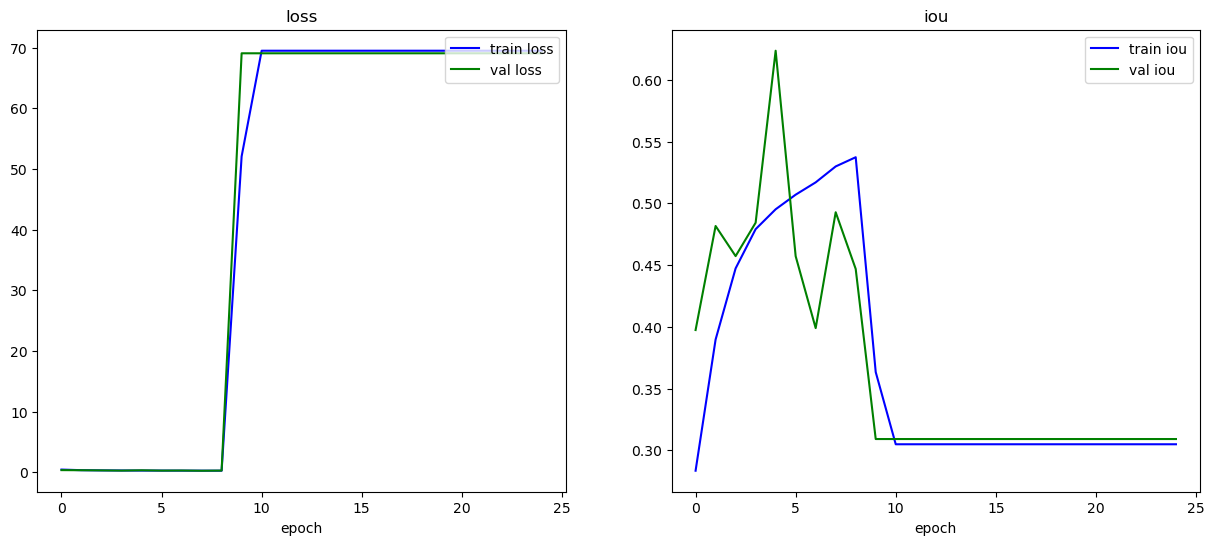

In [18]:
# Loss, IOU 값 시각화하기

train_loss_data = [i.detach().cpu().numpy() for i in train_loss_list]
val_loss_data = [i.detach().cpu().numpy() for i in val_loss_list]
# train_iou_data = [i.detach().cpu().numpy() for i in train_iou_list]
# val_iou_data = [i.detach().cpu().numpy() for i in val_iou_list]

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6)) 
plt.subplot(1,2,1)
plt.title('loss')
plt.xlabel('epoch')
plt.plot(train_loss_data, 'b', label='train loss')
plt.plot(val_loss_data, 'g', label='val loss')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.title('iou')
plt.xlabel('epoch')
plt.plot(train_iou_list, 'b', label='train iou')
plt.plot(val_iou_list, 'g', label='val iou')
plt.legend(loc='upper right')

plt.show()

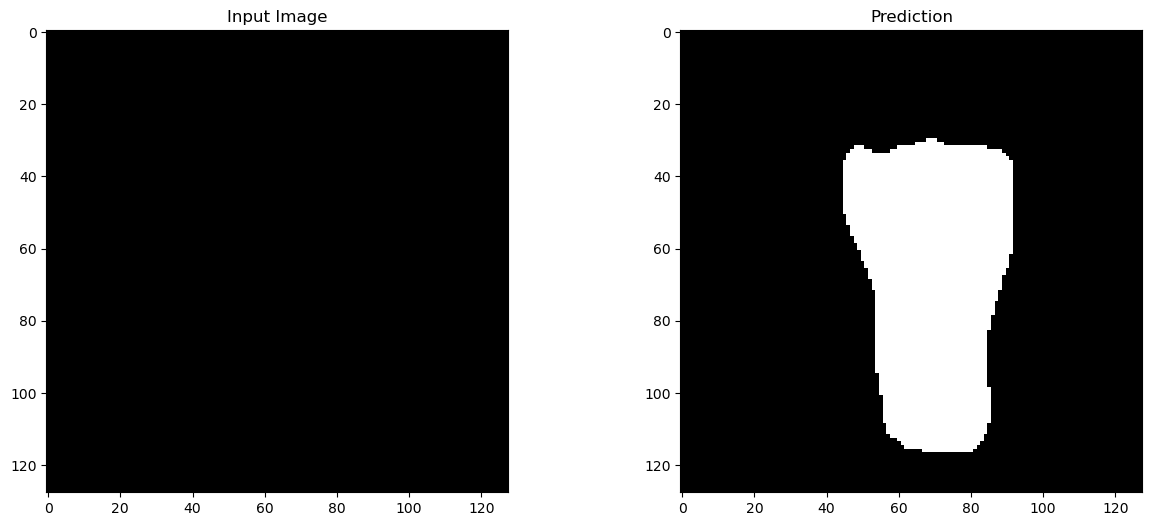

In [21]:
# 실제값, 예측값 시각화하기

for img_, mask_ in valid_loader:
    img = img_[1].to(device)
    img.unsqueeze_(0)
    mask_pred = model(img.float())
    mask_pred = mask_pred.cpu()
    mask_pred = (mask_pred > 0.75)
    mask_true = mask_[1]

    img = TF.to_pil_image(mask_pred.float().squeeze(0))
    mask = TF.to_pil_image(mask_true)

    img = np.array(img)
    mask = np.array(mask)

    fig, (axis_1, axis_2) = plt.subplots(1, 2, figsize=(15, 6))
    axis_1.imshow(img.astype(np.uint8), cmap='gray')
    axis_1.set_title('Input Image')
    axis_2.imshow(mask.astype(np.uint8), cmap='gray')
    axis_2.set_title('Prediction')
    plt.show()

    break

## Data augmentation 적용하여 학습하기

In [22]:
# Data augmentation 적용하여 학습하기

class ResUNetDataset_DAug(Dataset):
    def __init__(self, images_np, masks_np):
        self.images_np = images_np
        self.masks_np = masks_np
    
    def transform(self, image_np, mask_np):
        ToPILImage = transforms.ToPILImage()
        image = ToPILImage(image_np)
        mask = ToPILImage(mask_np.astype(np.int32))
        
        image = TF.pad(image, padding = 20, padding_mode = 'reflect')
        mask = TF.pad(mask, padding = 20, padding_mode = 'reflect')
        
        angle = random.uniform(-10, 10)
        width, height = image.size
        max_dx = 0.1 * width
        max_dy = 0.1 * height
        translations = (np.round(random.uniform(-max_dx, max_dx)), np.round(random.uniform(-max_dy, max_dy)))
        scale = random.uniform(0.8, 1.2)
        shear = random.uniform(-0.5, 0.5)
        image = TF.affine(image, angle = angle, translate = translations, scale = scale, shear = shear)
        mask = TF.affine(mask, angle = angle, translate = translations, scale = scale, shear = shear)
        
        image = TF.center_crop(image, (128, 128))
        mask = TF.center_crop(mask, (128, 128))
        
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        return image, mask

    def __len__(self):
        return len(self.images_np)
    
    def __getitem__(self, idx):
        image_np = self.images_np[idx]
        mask_np = self.masks_np[idx]
        image, mask = self.transform(image_np, mask_np)
        return image, mask

In [23]:
x_train = np.load('x_train_clsimb.npy')
y_train = np.load('y_train_clsimb.npy')
x_val = np.load('x_val.npy')
y_val = np.load('y_val.npy')

In [24]:
train_dataset = ResUNetDataset_DAug(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataset = ResUNetDataset_DAug(x_val, y_val)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

In [25]:
model2 = ResUNet(num_classes=1).to(device)
print(model2)

ResUNet(
  (contl_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (contl_2): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (resdl_1): ResidualBlock(
    (conv_block): Sequential(
      (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU()
      (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU()
      (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (shortcut): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
  (resdl_2): ResidualBlock(
    (conv_block): Sequential(
      (0): Batch

In [26]:
epochs = 25 
alpha = 5
batch_size = 16 
criterion=nn.BCELoss()
optimizer = optim.Adam(model2.parameters(), lr=1e-3)

In [27]:
train_loss_list = []
val_loss_list = []
train_iou_list = []
val_iou_list = []

for epoch in range(epochs):
    model2.train()
    train_loss = 0
    train_iou = 0

    for image, mask in train_loader:
        image = image.to(device)
        mask = mask.to(device)
        optimizer.zero_grad()
        outputs = model2(image.float())
    
        loss = criterion(outputs.float(), mask.float())
        train_loss += loss

        train_iou += iou_metric(outputs, mask)
        rev_iou = 16 - iou_metric(outputs, mask)
        loss += alpha * rev_iou

        loss.backward()
        optimizer.step()

    model2.eval()
    with torch.no_grad():
        valid_loss = 0
        valid_iou = 0

        for image_val, mask_val in valid_loader:
            image_val = image_val.to(device)
            mask_val = mask_val.to(device)
            output_val = model2(image_val.float())
            valid_loss += criterion(output_val.float(), mask_val.float())
            valid_iou += iou_metric(output_val, mask_val)

    print("Epoch ", epoch + 1, " Training Loss: ", train_loss/len(train_loader), "Validation Loss: ", valid_loss/len(valid_loader))
    print("Training mAP: ", train_iou/len(train_loader), "Validation mAP: ", valid_iou/len(valid_loader))

    # visualization
    train_loss_list.append(train_loss/len(train_loader))
    val_loss_list.append(valid_loss/len(valid_loader))
    train_iou_list.append(train_iou/len(train_loader))
    val_iou_list.append(valid_iou/len(valid_loader)
)


Epoch  1  Training Loss:  tensor(0.4465, device='mps:0', grad_fn=<DivBackward0>) Validation Loss:  tensor(0.4812, device='mps:0')
Training mAP:  0.28173971485514776 Validation mAP:  0.45273822302203326
Epoch  2  Training Loss:  tensor(0.3761, device='mps:0', grad_fn=<DivBackward0>) Validation Loss:  tensor(0.5147, device='mps:0')
Training mAP:  0.37153632828495725 Validation mAP:  0.16217336228672546
Epoch  3  Training Loss:  tensor(0.3434, device='mps:0', grad_fn=<DivBackward0>) Validation Loss:  tensor(0.4265, device='mps:0')
Training mAP:  0.41807822710108566 Validation mAP:  0.47964127447434524
Epoch  4  Training Loss:  tensor(20.6368, device='mps:0', grad_fn=<DivBackward0>) Validation Loss:  tensor(69.0654, device='mps:0')
Training mAP:  0.3911458918356694 Validation mAP:  0.30934559371751547
Epoch  5  Training Loss:  tensor(66.7689, device='mps:0', grad_fn=<DivBackward0>) Validation Loss:  tensor(68.8454, device='mps:0')
Training mAP:  0.3323109596772496 Validation mAP:  0.311545

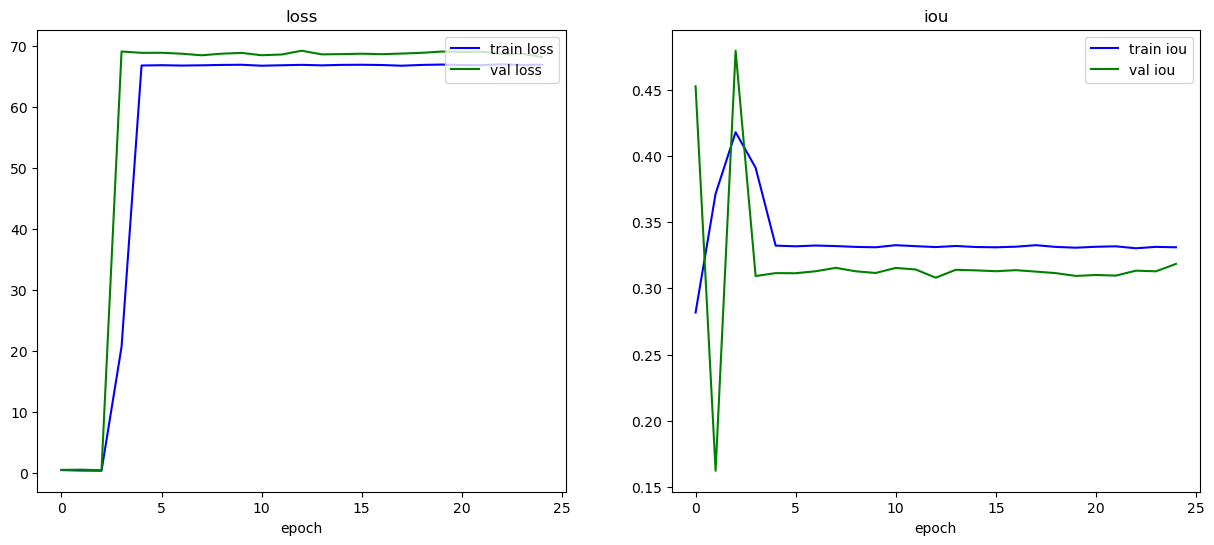

In [28]:
# Loss, IOU 값 시각화

train_loss_data = [i.detach().cpu().numpy() for i in train_loss_list]
val_loss_data = [i.detach().cpu().numpy() for i in val_loss_list]
# train_iou_data = [i.detach().cpu().numpy() for i in train_iou_list]
# val_iou_data = [i.detach().cpu().numpy() for i in val_iou_list]

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6)) 
plt.subplot(1,2,1)
plt.title('loss')
plt.xlabel('epoch')
plt.plot(train_loss_data, 'b', label='train loss')
plt.plot(val_loss_data, 'g', label='val loss')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.title('iou')
plt.xlabel('epoch')
plt.plot(train_iou_list, 'b', label='train iou')
plt.plot(val_iou_list, 'g', label='val iou')
plt.legend(loc='upper right')

plt.show()

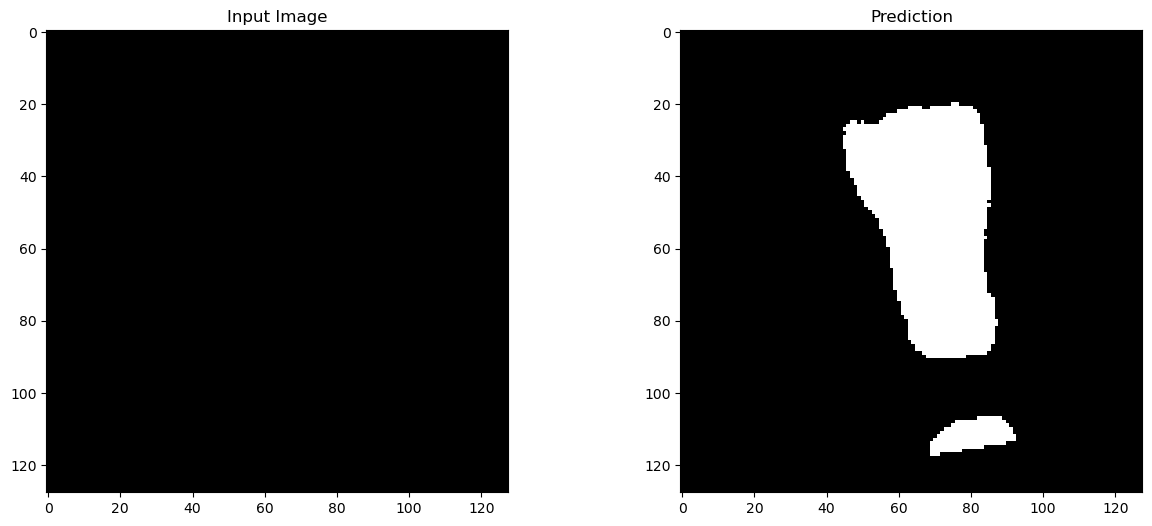

In [32]:
# Test 실제값, 예측값 시각화

for img_, mask_ in valid_loader:
    img = img_[1].to(device)
    img.unsqueeze_(0)
    mask_pred = model2(img.float())
    mask_pred = mask_pred.cpu()
    mask_pred = (mask_pred > 0.75)
    mask_true = mask_[1]

    img = TF.to_pil_image(mask_pred.float().squeeze(0))
    mask = TF.to_pil_image(mask_true)

    img = np.array(img)
    mask = np.array(mask)

    fig, (axis_1, axis_2) = plt.subplots(1, 2, figsize=(15, 6))
    axis_1.imshow(img.astype(np.uint8), cmap='gray')
    axis_1.set_title('Input Image')
    axis_2.imshow(mask.astype(np.uint8), cmap='gray')
    axis_2.set_title('Prediction')
    plt.show()

    break